In [1]:
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# Load arrays
X_seq_train = np.load("X_seq_train.npy")
X_seq_val   = np.load("X_seq_val.npy")
X_seq_test  = np.load("X_seq_test.npy")

X_pam_train = np.load("X_pam_train.npy")
X_pam_val   = np.load("X_pam_val.npy")
X_pam_test  = np.load("X_pam_test.npy")

X_gene_train = np.load("X_gene_train.npy")
X_gene_val   = np.load("X_gene_val.npy")
X_gene_test  = np.load("X_gene_test.npy")

X_cut_train = np.load("X_cut_train.npy")
X_cut_val   = np.load("X_cut_val.npy")
X_cut_test  = np.load("X_cut_test.npy")

y_train = np.load("y_train.npy")
y_val   = np.load("y_val.npy")
y_test  = np.load("y_test.npy")

In [4]:
print(X_seq_train.shape)
print(X_pam_train.shape)
print(X_gene_train.shape)
print(X_cut_train.shape)
print(y_train.shape)


(2596, 4, 20)
(2596, 4)
(2596,)
(2596, 1)
(2596, 1)


In [33]:
# Define a multi-input Dataset

class CRISPRDataset(Dataset):
  def __init__(self, X_seq, X_pam, X_gene, X_cut, y):
    self.X_seq = torch.tensor(X_seq, dtype = torch.float32)
    self.X_pam = torch.tensor(X_pam, dtype = torch.float32)
    self.X_gene = torch.tensor(X_gene, dtype = torch.long)
    self.X_cut = torch.tensor(X_cut, dtype = torch.float32)
    self.y = torch.tensor(y, dtype = torch.float32)

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return {
            "seq": self.X_seq[idx],
            "pam": self.X_pam[idx],
            "gene": self.X_gene[idx],
            "cut": self.X_cut[idx],
            "y": self.y[idx]
        }



In [34]:
# Dataloaders

batch_size = 64

train_loader = DataLoader(
    CRISPRDataset(X_seq_train, X_pam_train, X_gene_train, X_cut_train, y_train),
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    CRISPRDataset(X_seq_val, X_pam_val, X_gene_val, X_cut_val, y_val),
    batch_size=batch_size,
    shuffle=False
)

In [35]:
batch = next(iter(train_loader))

print(batch["gene"].dtype)  # MUST be torch.int64 / torch.long

torch.int64


In [36]:
# main model architecture design

# sequence CNN branch
class SequenceCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        return x



In [37]:
# gene embedding branch
class GeneEmbedding(nn.Module):
    def __init__(self, num_genes, embed_dim=6):
        super().__init__()
        self.embed = nn.Embedding(num_genes, embed_dim)

    def forward(self, x):
        return self.embed(x)

In [38]:
# PAM projection branch
class PAMProjector(nn.Module):
    def __init__(self, pam_dim, out_dim=4):
        super().__init__()
        self.fc = nn.Linear(pam_dim, out_dim)

    def forward(self, x):
        return F.relu(self.fc(x))

In [39]:
# full multi-input model
class CRISPRAggregateModel(nn.Module):
    def __init__(self, num_genes, pam_dim):
        super().__init__()

        self.seq_branch = SequenceCNN()
        self.gene_branch = GeneEmbedding(num_genes=num_genes, embed_dim=6)
        self.pam_branch = PAMProjector(pam_dim=pam_dim, out_dim=4)

        self.regressor = nn.Sequential(
            nn.Linear(64 + 6 + 4 + 1, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, seq, pam, gene, cut):
        seq_feat = self.seq_branch(seq)
        gene_feat = self.gene_branch(gene)
        pam_feat = self.pam_branch(pam)

        x = torch.cat([seq_feat, gene_feat, pam_feat, cut], dim=1)
        return self.regressor(x)

In [40]:
with open("gene2id.json") as f:
    num_genes = len(json.load(f))

pam_dim = X_pam_train.shape[1]

model = CRISPRAggregateModel(
    num_genes=num_genes,
    pam_dim=pam_dim
).to(device)

# sanity check
batch = next(iter(train_loader))

out = model(
    batch["seq"].to(device),
    batch["pam"].to(device),
    batch["gene"].to(device),
    batch["cut"].to(device)
)

print(out.shape)


torch.Size([64, 1])


In [41]:
# Training loop

model = CRISPRAggregateModel(
    num_genes = len(json.load(open("gene2id.json"))),
    pam_dim = X_pam_train.shape[1]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.MSELoss()

# training loop
def train_one_epoch(model, loader):
  model.train()
  losses=[]

  for batch in loader:
    optimizer.zero_grad()

    y_pred = model(
        batch["seq"].to(device),
        batch["pam"].to(device),
        batch["gene"].to(device),
        batch["cut"].to(device)
    )

    loss = criterion(y_pred, batch["y"].to(device))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  return np.mean(losses)

#validation loop
def evaluate(model, loader):
  model.eval()
  ys, preds = [], []

  with torch.no_grad():
    for batch in loader:
            y_pred = model(
                batch["seq"].to(device),
                batch["pam"].to(device),
                batch["gene"].to(device),
                batch["cut"].to(device)
            )

            preds.append(y_pred.cpu().numpy())
            ys.append(batch["y"].cpu().numpy())

    return mean_squared_error(
        np.vstack(ys), np.vstack(preds)
    )




In [42]:
num_epochs = 15

train_losses = []
val_losses = []

In [43]:
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train MSE: {train_loss:.4f} | "
        f"Val MSE: {val_loss:.4f}"
    )

Epoch 01 | Train MSE: 0.1138 | Val MSE: 0.0818
Epoch 02 | Train MSE: 0.0862 | Val MSE: 0.0731
Epoch 03 | Train MSE: 0.0771 | Val MSE: 0.0674
Epoch 04 | Train MSE: 0.0688 | Val MSE: 0.0562
Epoch 05 | Train MSE: 0.0561 | Val MSE: 0.0454
Epoch 06 | Train MSE: 0.0478 | Val MSE: 0.0365
Epoch 07 | Train MSE: 0.0408 | Val MSE: 0.0302
Epoch 08 | Train MSE: 0.0342 | Val MSE: 0.0250
Epoch 09 | Train MSE: 0.0315 | Val MSE: 0.0214
Epoch 10 | Train MSE: 0.0263 | Val MSE: 0.0189
Epoch 11 | Train MSE: 0.0245 | Val MSE: 0.0169
Epoch 12 | Train MSE: 0.0210 | Val MSE: 0.0152
Epoch 13 | Train MSE: 0.0205 | Val MSE: 0.0141
Epoch 14 | Train MSE: 0.0189 | Val MSE: 0.0140
Epoch 15 | Train MSE: 0.0180 | Val MSE: 0.0113


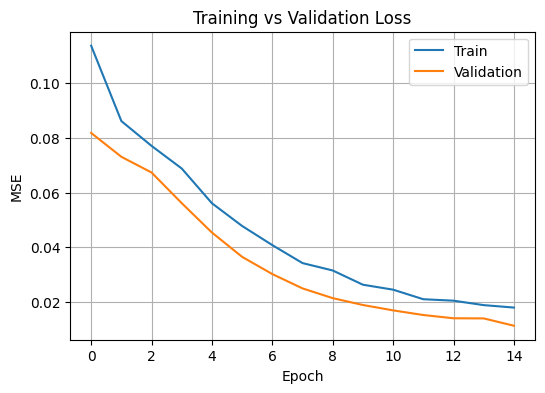

In [45]:
plt.figure(figsize = (6, 4))
plt.plot(train_losses, label = "Train")
plt.plot(val_losses, label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_vs_validation_day12.png")
plt.show()

In [46]:
# prediction distribution check

model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch in val_loader:
        y_pred = model(
            batch["seq"].to(device),
            batch["pam"].to(device),
            batch["gene"].to(device),
            batch["cut"].to(device),
        )

        y_true_list.append(batch["y"].cpu().numpy())
        y_pred_list.append(y_pred.cpu().numpy())

y_true = np.vstack(y_true_list).flatten()
y_pred = np.vstack(y_pred_list).flatten()

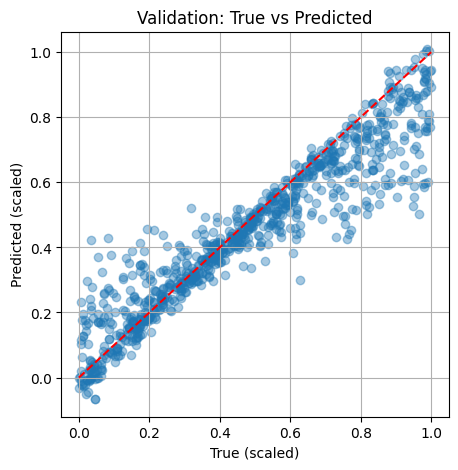

In [49]:
plt.figure(figsize = (5, 5))
plt.scatter(y_true, y_pred, alpha = 0.4)
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("True (scaled)")
plt.ylabel("Predicted (scaled)")
plt.title("Validation: True vs Predicted")
plt.savefig("true_vs_pred_val_day12.png")
plt.grid(True)
plt.show()

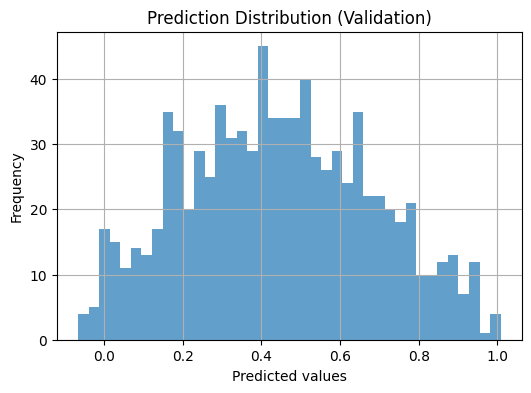

In [50]:
plt.figure(figsize=(6,4))
plt.hist(y_pred, bins=40, alpha=0.7)
plt.xlabel("Predicted values")
plt.ylabel("Frequency")
plt.title("Prediction Distribution (Validation)")
plt.grid(True)
plt.savefig("prediction_distribution_day12")
plt.show()
